Une des méthodes que nous avons poursuivie est celle-ci, d'après l'article suivant : "2-Line Exhaustive Searching for Real-Time Vanishing Point Estimation in Manhattan World". Cet article présente une méthode innovante pour l'estimation des points de fuite (vanishing points, VPs) dans des images calibrées en utilisant une stratégie basée sur deux lignes.

### Méthode proposée
La méthode exposée dans l'article s'intègre dans un algorithme en trois étapes principales : la construction d'une grille polaire, la génération d'hypothèses de points de fuite, et la validation de ces hypothèses. Ces étapes exploitent à la fois des techniques de vision par ordinateur et des concepts mathématiques avancés pour une estimation précise et rapide des points de fuite.

#### 1. **Construction de la Grille Polaire**
Dans l'algorithme, la construction de la grille polaire est la première étape. Cette grille est centrée sur le point principal de l'image et utilise une sphère équivalente pour représenter les coordonnées sphériques des pixels de l'image. Elle permet d'accumuler les réponses des segments de ligne dans la grille, facilitant ainsi la détermination des points de fuite.

#### 2. **Génération des Hypothèses**
La génération des hypothèses de points de fuite s'intègre à l'algorithme par l'utilisation d'une paire de lignes pour générer un premier point de fuite. Cette sélection est réalisée de manière à maximiser la probabilité que les lignes soient parallèles dans le monde réel et convergent vers un point de fuite dans l'image. Les deux autres points de fuite sont ensuite calculés en tenant compte de l'orthogonalité entre les trois points.

#### 3. **Validation des Hypothèses**
Dans l'algorithme, la validation des hypothèses générées est effectuée en consultant la grille polaire pour chaque trio de points de fuite hypothétiques. Le trio qui maximise la réponse cumulée dans la grille polaire est choisi comme l'estimation finale des points de fuite de l'image. Cette étape permet de confirmer que les points de fuite sélectionnés correspondent bien aux configurations les plus probables de lignes dans l'image.

### Fondements Théoriques
Les fondements théoriques de cette méthode reposent sur la géométrie projective et les transformations géométriques. L'utilisation de coordonnées sphériques facilite la manipulation et la comparaison des directions et des angles dans l'image, essentielle pour la projection et l'intersection des lignes. De plus, l'approche exhaustive combinée à un modèle probabiliste pour la sélection des lignes permet de surmonter les limitations des méthodes basées uniquement sur RANSAC, souvent sujettes à des solutions locales non optimales.

En somme, l'article présente une méthode robuste et efficace pour la détection des points de fuite dans des environnements urbains structurés. Elle combine la précision mathématique avec des techniques de vision par ordinateur avancées pour fournir des estimations rapides et fiables, cruciales pour des applications telles que la navigation autonome et la modélisation 3D à partir d'images urbaines.

In [28]:
#Créons un chemin pour le dossier Dataset à l'aide du module os

import os
path = os.getcwd() + '/Road_Annotated_Dataset'
print(path)

c:\Users\danre\VanishingPointDetection_CS/Road_Annotated_Dataset


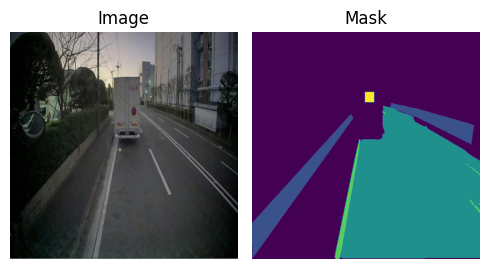

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

image_path_1 = path + '/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160.jpg'
image_path_2 = path + '/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160_mask.png'
image_1 = Image.open(image_path_1)
image_2 = Image.open(image_path_2)


fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Plot the first image
axes[0].imshow(image_1)
axes[0].axis('off')  # Hide axes for image 1
axes[0].set_title('Image') # Optional title

# Plot the second image
axes[1].imshow(image_2)
axes[1].axis('off')  # Hide axes for image 2
axes[1].set_title('Mask') # Optional title

# Display the images
plt.tight_layout()
plt.show()


In [ ]:

import cv2
import numpy as np
from itertools import combinations

class VPDetection(object):
    """
    VP Detection Object

    Args:
        length_thresh: Line segment detector threshold (default=30)
        principal_point: Principal point of the image (in pixels)
        focal_length: Focal length of the camera (in pixels)
        seed: Seed for reproducibility due to RANSAC
    """

    """
    This class handles the detection of vanishing points in images using geometric properties
    of lines within the image. It leverages methods such as line detection, vanishing point
    hypothesis generation, and a clustering-based approach for hypothesis validation.
    """
    def __init__(self, length_thresh=30, principal_point=None, focal_length=1500, seed=None):
        # Initializes the detector with various parameters including thresholds and camera characteristics.
        self._length_thresh = length_thresh
        self._principal_point = principal_point
        self._focal_length = focal_length
        self._angle_thresh = np.pi / 30  # Threshold for clustering lines in debug images
        self._vps = None  # 3D coordinates of detected vanishing points
        self._vps_2D = None  # 2D coordinates of detected vanishing points
        self.__img = None  # The image being processed
        self.__clusters = None  # Indices of lines corresponding to each vanishing point
        self.__tol = 1e-8  # Numerical tolerance for floating point operations
        self.__angle_tol = np.pi / 3  # Tolerance for angular comparisons in radians
        self.__lines = None  # Detected lines stored as an array of endpoints
        self.__zero_value = 0.001  # Used to handle division by zero in homogeneous coordinates
        self.__seed = seed  # Random seed for reproducibility
        noise_ratio = 0.5  # Assumed ratio of outliers to inliers in line detection
        p = (1.0 / 3.0) * ((1.0 - noise_ratio)**2.0)  # Probability used to compute RANSAC iterations
        conf = 0.9999  # Confidence level for RANSAC
        self.__ransac_iter = int(np.log(1 - conf) / np.log(1.0 - p))  # Number of RANSAC iterations

    @property
    def length_thresh(self):
        """
        Length threshold for line segment detector

        Returns:
            The minimum length required for a line
        """
        return self._length_thresh
    @length_thresh.setter
    def length_thresh(self, value):
        """
        Length threshold for line segment detector

        Args:
            value: The minimum length required for a line

        Raises:
            ValueError: If the threshold is 0 or negative
        """
        if value <= 0:
            raise ValueError('Invalid threshold: {}'.format(value))

        self._length_thresh = value
    @property
    def principal_point(self):
        """
        Principal point for VP Detection algorithm

        Returns:
            The minimum length required for a line
        """
        return self._principal_point
    @principal_point.setter
    def principal_point(self, value):
        """
        Principal point for VP Detection algorithm

        Args:
            value: A list or tuple of two elements denoting the x and y
           coordinates

        Raises:
            ValueError: If the input is not a list or tuple and there aren't
            two elements
        """
        try:
            assert isinstance(value,
                              (list, tuple)) and not isinstance(value, str)
            assert len(value) == 2
        except AssertionError:
            raise ValueError('Invalid principal point: {}'.format(value))

        self._length_thresh = value
    @property
    def focal_length(self):
        """
        Focal length for VP detection algorithm

        Returns:
            The focal length in pixels
        """
        return self._focal_length
    @focal_length.setter
    def focal_length(self, value):
        """
        Focal length for VP detection algorithm

        Args:
            value: The focal length in pixels

        Raises:
            ValueError: If the input is 0 or negative
        """
        if value < self.__tol:  # If the focal length is too small, reject
            raise ValueError('Invalid focal length: {}'.format(value))

        self._focal_length = value
    @property
    def vps(self):
        """
        Vanishing points of the image in 3D space.

        Returns:
            A numpy array where each row is a point and each column is a
            component / coordinate
        """
        return self._vps
    @property
    def vps_2D(self):
        """
        Vanishing points of the image in 2D image coordinates.

        Returns:
            A numpy array where each row is a point and each column is a
            component / coordinate
        """
        return self._vps_2D

    def __detect_lines(self, img):
        """
        Detects lines using OpenCV LSD Detector
        """
        # Convert to grayscale if required
        if len(img.shape) == 3:
            img_copy = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_copy = img

        # Create LSD detector with default parameters
        lsd = cv2.createLineSegmentDetector(0)

        # Detect lines in the image
        # Returns a NumPy array of type N x 1 x 4 of float32
        # such that the 4 numbers in the last dimension are (x1, y1, x2, y2)
        # These denote the start and end positions of a line
        lines = lsd.detect(img_copy)[0]

        # Remove singleton dimension
        lines = lines[:, 0]

        # Filter out the lines whose length is lower than the threshold
        dx = lines[:, 2] - lines[:, 0]
        dy = lines[:, 3] - lines[:, 1]
        lengths = np.sqrt(dx * dx + dy * dy)
        mask = lengths >= self._length_thresh
        lines = lines[mask]

        # Store the lines internally
        self.__lines = lines

        # Return the lines
        return lines

    def __find_vp_hypotheses_two_lines(self):
        """
        Finds the VP hypotheses using pairs of lines
        """
        # Number of detected lines
        N = self.__lines.shape[0]

        # Number of bins for longitude - 360 bins so 1 deg. per bin
        # For estimating second VP along the great circle distance of the
        # first VP
        num_bins_vp2 = 360
        vp2_step = np.pi / 180.0  # Step in radians

        # Store the equations of the line, lengths and orientations
        # for each line segment
        p1 = np.column_stack((self.__lines[:, :2], np.ones(N,
                                                           dtype=np.float32)))
        p2 = np.column_stack((self.__lines[:, 2:], np.ones(N,
                                                           dtype=np.float32)))
        cross_p = np.cross(p1, p2)
        dx = p1[:, 0] - p2[:, 0]
        dy = p1[:, 1] - p2[:, 1]
        lengths = np.sqrt(dx * dx + dy * dy)
        orientations = np.arctan2(dy, dx)

        # Perform wraparound - [-pi, pi] --> [0, pi]
        # All negative angles map to their mirrored positive counterpart
        orientations[orientations < 0] = orientations[orientations < 0] + np.pi

        # Keep these around
        self.__cross_p = cross_p
        self.__lengths = lengths
        self.__orientations = orientations

        # Stores the VP hypotheses - 3 per longitude for each RANSAC iteration
        # First dimension - VP triplet proposal for a RANSAC iteration
        # Second dimension - VPs themselves
        # Third dimension - VP component
        vp_hypos = np.zeros((self.__ransac_iter * num_bins_vp2, 3, 3),
                            dtype=np.float32)

        i = 0

        if self.__seed is not None:
            gen = np.random.RandomState(self.__seed)

        # For each iteration...
        while i < self.__ransac_iter:
            # Get two random indices
            if self.__seed is not None:
                (idx1, idx2) = gen.permutation(N)[:2]
            else:
                (idx1, idx2) = np.random.permutation(N)[:2]

            # Get the first VP proposal in the image
            vp1_img = np.cross(cross_p[idx1], cross_p[idx2])

            # Try again if at infinity
            if np.abs(vp1_img[2]) < self.__tol:
                continue

            # Find where it intersects in the sphere
            vp1 = np.zeros(3, dtype=np.float32)
            vp1[:2] = vp1_img[:2] / vp1_img[2] - self._principal_point
            vp1[2] = self._focal_length

            # Normalize
            vp1 /= np.sqrt(np.sum(np.square(vp1)))

            # Get the other two VPs
            # Search along the circumference of the sphere
            la = np.arange(num_bins_vp2) * vp2_step
            kk = vp1[0] * np.sin(la) + vp1[1] * np.cos(la)
            phi = np.arctan(-vp1[2] / kk)

            # Convert back to Cartesian coordinates
            vp2 = np.column_stack([
                np.sin(phi) * np.sin(la),
                np.sin(phi) * np.cos(la),
                np.cos(phi)
            ])

            # Enforce points at infinity to be finite
            vp2[np.abs(vp2[:, 2]) < self.__tol, 2] = self.__zero_value
            # Normalize
            vp2 /= np.sqrt(np.sum(np.square(vp2), axis=1, keepdims=True))
            vp2[vp2[:, 2] < 0, :] *= -1.0  # Ensure direction is +z

            vp3 = np.cross(vp1, vp2)  # Third VP is orthogonal to the two
            vp3[np.abs(vp3[:, 2]) < self.__tol, 2] = self.__zero_value
            vp3 /= np.sqrt(np.sum(np.square(vp3), axis=1, keepdims=True))
            vp3[vp3[:, 2] < 0, :] *= -1.0

            # Place proposals in corresponding locations
            vp_hypos[i * num_bins_vp2:(i + 1) * num_bins_vp2, 0, :] = vp1
            vp_hypos[i * num_bins_vp2:(i + 1) * num_bins_vp2, 1, :] = vp2
            vp_hypos[i * num_bins_vp2:(i + 1) * num_bins_vp2, 2, :] = vp3

            # Move to the next iteration
            i += 1

        return vp_hypos

    def __get_sphere_grids(self):
        """
        Builds spherical voting grid to determine which VP has the most support
        """

        # Determine number of bins for latitude and longitude
        bin_size = np.pi / 180.0
        lat_span = np.pi / 2.0
        long_span = 2.0 * np.pi
        num_bins_lat = int(lat_span / bin_size)
        num_bins_lon = int(long_span / bin_size)

        # Get indices for every unique pair of lines
        combos = list(combinations(range(self.__lines.shape[0]), 2))
        combos = np.asarray(combos, dtype=int)

        # For each pair, determine where the lines intersect
        pt_intersect = np.cross(self.__cross_p[combos[:, 0]],
                                self.__cross_p[combos[:, 1]])

        # Ignore if points are at infinity
        mask = np.abs(pt_intersect[:, 2]) >= self.__tol

        # To determine if two points map to the same VP in spherical
        # coordinates, their difference in angle must be less than
        # some threshold
        ang = np.abs(self.__orientations[combos[:, 0]] -
                     self.__orientations[combos[:, 1]])
        ang = np.minimum(np.pi - ang, ang)
        mask = np.logical_and(mask, np.abs(ang) <= self.__angle_tol)

        # Get the points, angles and combinations that are
        # left
        pt_intersect = pt_intersect[mask]
        ang = ang[mask]
        combos = combos[mask]

        # Determine corresponding lat and lon mapped to the sphere
        X = (pt_intersect[:, 0] /
             pt_intersect[:, 2]) - self._principal_point[0]
        Y = (pt_intersect[:, 1] /
             pt_intersect[:, 2]) - self._principal_point[1]
        Z = self._focal_length
        lat = np.arccos(Z / np.sqrt(X * X + Y * Y + Z * Z))
        lon = np.arctan2(X, Y) + np.pi

        # Get corresponding bin locations
        la_bin = (lat / bin_size).astype(int)
        lon_bin = (lon / bin_size).astype(int)
        la_bin[la_bin >= num_bins_lat] = num_bins_lat - 1
        lon_bin[lon_bin >= num_bins_lon] = num_bins_lon - 1

        # Add their weighted vote to the corresponding bin
        # Get 1D bin coordinate so we can take advantage
        # of bincount method, then reshape back to 2D
        bin_num = la_bin * num_bins_lon + lon_bin
        weights = np.sqrt(
            self.__lengths[combos[:, 0]] *
            self.__lengths[combos[:, 1]]) * (np.sin(2.0 * ang) + 0.2)

        sphere_grid = np.bincount(
            bin_num, weights=weights,
            minlength=num_bins_lat * num_bins_lon).reshape(
                (num_bins_lat, num_bins_lon)).astype(np.float32)

        # Add the 3 x 3 smoothed votes on top of the original votes for
        # stability (refer to paper)
        sphere_grid += cv2.filter2D(sphere_grid, -1, (1.0 / 9.0) * np.ones(
            (3, 3)))
        return sphere_grid

    def __get_best_vps_hypo(self, sphere_grid, vp_hypos):
        # Number of hypotheses
        N = vp_hypos.shape[0]

        # Bin size - 1 deg. in radians
        bin_size = np.pi / 180.0

        # Ignore any values whose augmented coordinate are less than
        # the threshold or bigger than magnitude of 1
        # Each row is a VP triplet
        # Each column is the z coordinate
        mask = np.logical_and(
            np.abs(vp_hypos[:, :, 2]) >= self.__tol,
            np.abs(vp_hypos[:, :, 2]) <= 1.0)

        # Create ID array for VPs
        ids = np.arange(N).astype(int)
        ids = np.column_stack([ids, ids, ids])
        ids = ids[mask]

        # Calculate their respective lat and lon
        lat = np.arccos(vp_hypos[:, :, 2][mask])
        lon = np.arctan2(vp_hypos[:, :, 0][mask],
                         vp_hypos[:, :, 1][mask]) + np.pi

        # Determine which bin they map to
        la_bin = (lat / bin_size).astype(int)
        lon_bin = (lon / bin_size).astype(int)
        la_bin[la_bin == 90] = 89
        lon_bin[lon_bin == 360] = 359

        # For each hypotheses triplet of VPs, calculate their final
        # votes by summing the contributions of each VP for the
        # hypothesis
        weights = sphere_grid[la_bin, lon_bin]
        votes = np.bincount(ids, weights=weights,
                            minlength=N).astype(np.float32)

        # Find best hypothesis by determining which triplet has the largest
        # votes
        best_idx = np.argmax(votes)
        final_vps = vp_hypos[best_idx]
        vps_2D = self._focal_length * (final_vps[:, :2] /
                                       final_vps[:, 2][:, None])
        vps_2D += self._principal_point

        # Find the coordinate with the largest vertical value
        # This will be the last column of the output
        z_idx = np.argmax(np.abs(vps_2D[:, 1]))
        ind = np.arange(3).astype(int)
        mask = np.ones(3, dtype=bool)
        mask[z_idx] = False
        ind = ind[mask]

        # Next, figure out which of the other two coordinates has the smallest
        # x coordinate - this would be the left leaning VP
        vps_trim = vps_2D[mask]
        x_idx = np.argmin(vps_trim[:, 0])
        x_idx = ind[x_idx]

        # Finally get the right learning VP
        mask[x_idx] = False
        x2_idx = np.argmax(mask)

        # Re-arrange the order
        # Right VP is first - x-axis would be to the right
        # Left VP is second - y-axis would be to the left
        # Vertical VP is third - z-axis would be vertical
        final_vps = final_vps[[x2_idx, x_idx, z_idx], :]
        vps_2D = vps_2D[[x2_idx, x_idx, z_idx], :]

        # Save for later
        self._vps = final_vps
        self._vps_2D = vps_2D
        return final_vps

    def __cluster_lines(self, vps_hypos):
        """
        Groups the lines based on which VP they contributed to.
        Primarily for display purposes only when debugging the algorithm
        """

        # Extract out line coordinates
        x1 = self.__lines[:, 0]
        y1 = self.__lines[:, 1]
        x2 = self.__lines[:, 2]
        y2 = self.__lines[:, 3]

        # Get midpoint of each line
        xc = (x1 + x2) / 2.0
        yc = (y1 + y2) / 2.0

        # Get the direction vector of the line detection
        # Also normalize
        dx = x1 - x2
        dy = y1 - y2
        norm_factor = np.sqrt(dx * dx + dy * dy)
        dx /= norm_factor
        dy /= norm_factor

        # Get the direction vector from each detected VP
        # to the midpoint of the line and normalize
        xp = self._vps_2D[:, 0][:, None] - xc[None]
        yp = self._vps_2D[:, 1][:, None] - yc[None]
        norm_factor = np.sqrt(xp * xp + yp * yp)
        xp /= norm_factor
        yp /= norm_factor

        # Calculate the dot product then find the angle between the midpoint
        # of each line and each VPs
        # We calculate the angle that each make with respect to each line and
        # and choose the VP that has the smallest angle with the line
        dotp = dx[None] * xp + dy[None] * yp
        dotp[dotp > 1.0] = 1.0
        dotp[dotp < -1.0] = -1.0
        ang = np.arccos(dotp)
        ang = np.minimum(np.pi - ang, ang)

        # For each line, which VP is the closest?
        # Get both the smallest angle and index of the smallest
        min_ang = np.min(ang, axis=0)
        idx_ang = np.argmin(ang, axis=0)

        # Don't consider any lines where the smallest angle is larger than
        # a similarity threshold
        mask = min_ang <= self._angle_thresh

        # For each VP, figure out the line indices
        # Create a list of 3 elements
        # Each element contains which line index corresponds to which VP
        self.__clusters = [
            np.where(np.logical_and(mask, idx_ang == i))[0] for i in range(3)
        ]

    def find_vps(self, img):
        """
        Find the vanishing points given the input image

        Args:
            img: Either the path to the image or the image read in with
         `cv2.imread`

        Returns:
            A numpy array where each row is a point and each column is a
            component / coordinate. Additionally, the VPs are ordered such that
            the right most VP is the first row, the left most VP is the second
            row and the vertical VP is the last row
        """

        # Detect the lines in the image
        if isinstance(img, str):
            img = cv2.imread(img, -1)

        self.__img = img  # Keep a copy for later

        # Reset principal point if we haven't set it yet
        if self._principal_point is None:
            rows, cols = img.shape[:2]
            self._principal_point = np.array([cols / 2.0, rows / 2.0],
                                             dtype=np.float32)

        # Detect lines
        _ = self.__detect_lines(img)

        # Find VP candidates
        vps_hypos = self.__find_vp_hypotheses_two_lines()
        self.__vps_hypos = vps_hypos  # Save a copy

        # Map VP candidates to sphere
        sphere_grid = self.__get_sphere_grids()

        # Find the final VPs
        best_vps = self.__get_best_vps_hypo(sphere_grid, vps_hypos)
        self.__final_vps = best_vps  # Save a copy
        self.__clusters = None  # Reset because of new image
        return best_vps

    def create_debug_VP_image(self, show_image=False):
        """
        Once the VP detection algorithm runs, show which lines belong to
        which clusters by colouring the lines according to which VP they
        contributed to.

        Args:
            show_image: Display the image within the Jupyter notebook (default=False)

        Returns:
            The debug image
        """
        # Group the line detections based on which VP they belong to
        # Only run if we haven't done it yet for this image
        if self.__clusters is None:
            self.__cluster_lines(self.__vps_hypos)

        img = self.__img.copy()
        if len(img.shape) == 2:  # If grayscale, artificially make into RGB
            img = np.dstack([img, img, img])

        colours = 255 * np.eye(3)
        # BGR format
        # First row is red, second green, third blue
        colours = colours[:, ::-1].astype(int).tolist()

        # Draw the outlier lines as black
        all_clusters = np.hstack(self.__clusters)
        status = np.ones(self.__lines.shape[0], dtype=bool)
        status[all_clusters] = False
        ind = np.where(status)[0]
        for (x1, y1, x2, y2) in self.__lines[ind]:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 2, cv2.LINE_AA)

        # For each cluster of lines, draw them in their right colour
        for i in range(3):
            for (x1, y1, x2, y2) in self.__lines[self.__clusters[i]]:
                cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)),
                        colours[i], 2, cv2.LINE_AA)

        # Show image if necessary
        if show_image:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')  # Turn off axis numbers and ticks
            plt.show()

        return img

In [ ]:
Utilisation de la classe pour détecter les points de fuite

SyntaxError: invalid syntax (3388468945.py, line 1)

[[ 0.04471333 -0.9462793   0.32024407]
 [-0.18459544  0.3072184   0.9335638 ]
 [ 0.981797    0.10085835  0.16094208]]


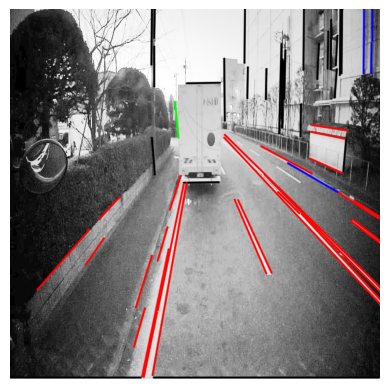

[[326.98114 172.25655]
 [310.1134  336.45407]
 [625.0156  351.33374]]


In [33]:


# Charger l'image
image_path = image_path_1
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Égalisation d'histogramme (optionnelle pour améliorer le contraste)
equalized_image = cv2.equalizeHist(gray_image)

#data needed for the vpd algorithm

length_thresh=50
principal_point=None
focal_length=50
seed=None

# Run detection

vpd = VPDetection(length_thresh, principal_point, focal_length, seed)
vps = vpd.find_vps(equalized_image)
# Display vanishing points
print(vps)
vpd.create_debug_VP_image(show_image=True)
# You can also access the VPs directly as a property
# Only works when you run the algorithm first
vps = vpd.vps
# You can also access the image coordinates for the vanishing points
# Only works when you run the algorithm first
vps_2D = vpd.vps_2D
print(vps_2D)